Here, I try to simulate the patterns obtained on a sandy terrain. This is what is observed when the wind blows on the dry surface of a land with sand or also on the surface of the sea in the presence of currents.

As described in https://en.wikipedia.org/wiki/Dune, 

> When a sandy seabed is subject to wave action and the wave orbital motion is strong enough to move sand grains, ripples often appear. The ripples induced by wave action are called “wave ripples”; their characteristics being different from those of the ripples generated by steady flows. The most striking difference between wave ripple fields and current ripple fields is the regularity of the former. Indeed, regular long-crested wave ripple fields are often observed on tidal beaches from which the sea has withdrawn at low water (see figure 1). 

A nice example is shown in http://www.coastalwiki.org/wiki/Wave_ripple_formation showing

> Ripples observed at Sea Rim State Park, along the coast of east Texas close to the border with Louisiana (courtesy by Zoltan Sylvester).
![](http://www.coastalwiki.org/w/images/6/65/WaveRippleFormationFig0.jpg)

[Wave ripple formation](http://www.coastalwiki.org/wiki/Wave_ripple_formation)

An interesting aspect of that patterns is that they may occur at different scales, like taht example on the surface of the Mars planet:

> Overview of large sand wave field and high-resolution difference map of two surveys approximately 21 hours apart illustrating both large-scale and small-scale sand wave migration and orientation. Migration is from right to left.

![](https://www.researchgate.net/profile/Daniel-Hanes/publication/252161559/figure/fig1/AS:669991225552924@1536749764962/Overview-of-large-sand-wave-field-and-high-resolution-difference-map-of-two-surveys.png)


<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
import matplotlib
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
#%config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
fig_width = 10
subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., hspace=0., wspace=0.05,)

In [2]:
# Importing libraries
import torch
import torch.nn.functional as nnf
torch.manual_seed(1998) 
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

torch.__version__, device

('2.0.0', device(type='mps'))

## Wave & wind ripples

Such ripples can be charcterized using the physical process that generate them: 

> Sea waves shape the bottom and generate different morphological patterns, which are characterized by a wide range of length scales. The ripples are the smallest bedforms but, notwithstanding their relatively small size, they play a prominent role in many transport processes. Indeed, usually, the flow separates at their crests and vortices are generated which increase momentum transfer, sediment transport and, in general, mixing phenomena.  (from http://www.coastalwiki.org/wiki/Wave_ripples)

And can be formalized using simple iterative process like that described in http://nishitalab.org/user/nis/cdrom/pg/onoue.pdf or a more complex example shown in https://www.hindawi.com/journals/jam/2014/590358/

We will try to give a simple formulation and first initialize the parameters:

In [3]:
from dataclasses import dataclass, asdict
DEBUG = 2
DEBUG = 1

@dataclass
class Params:
    bins: int = 2**(8//DEBUG)
    N_particles: int = 2**(8*2) * 4
    N_step: int = 2**(10//DEBUG)
    L: float = 1 / 2**6 # saltation step in the y direction
    kappa: float = 4.0
    D: float = 7.e-4 # diffusion per step
    seed : int = 1998

p = Params()
p

Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)

The dynamical system can be formalized by the following equations.

Diffusion step with $\nu$ a normal noise:
$$
\vec{x}_i \leftarrow \vec{x}_i + D \cdot \nu
$$ 
where $\vec{x}_i = (x_i, y_i)$ corresponds to the position of the $i$-th particle.

We may compute the local height as the density of particle:
$$
h(\vec{x}) = \# \{ \vec{x}_i=\vec{x} | 1 \le i \le N \}
$$
This is in practice defined on a local grid and with a finite number $N$ of particles.

We may finally define a saltation step in the wind direction direction:
$$
y_i \leftarrow y_i + L \cdot \sigma( - \kappa * h(\vec{x}))
$$
where $\sigma$ is the sigmoid function $\sigma(x) = \frac 1 {1 + \exp(-x)} $. For computational tractability, coordinates are finally remapped on the torus.

Interestingly, this type of model combining a linear diffusion and a non-linear scaling is found in many different physical systems, including neural systems (random recurrent neural fields for instance) and has a long history in computational neuroscience. The implementation we chose is slightly different as the field is defined by particles, reminiscent of our previous work on modelling [motion detection in the visual system](https://laurentperrinet.github.io/publication/perrinet-12-pred/).


The dynamical system can be simplified in the following code which models the terrain by sand particles and then estimates the terrain using a spatial histogram. First, we code it in numpy:

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def wind_ripples(p):

    binz = [np.linspace(0, 1, p.bins+1, endpoint=True), np.linspace(0, 1, p.bins+1, endpoint=True)]
    np.random.seed(p.seed)
    x, y = np.random.rand(p.N_particles), np.random.rand(p.N_particles)

    for i_step in range(p.N_step):
        
        x, y = x + p.D/np.sqrt(i_step+1)*np.random.randn(p.N_particles), y + p.D/np.sqrt(i_step+1)*np.random.randn(p.N_particles)    
        x, y = x % 1, y % 1

        height, edge_x, edge_y = np.histogram2d(x, y, bins=binz, density=True)
        
        ind_x, ind_y = (x*p.bins).astype(int), (y*p.bins).astype(int)

        y += p.L * sigmoid( - p.kappa * height[ind_x, ind_y])

    return height

Which runs on the CPU in about 50s:

In [5]:
%timeit -n1 -r1 wind_ripples(Params(N_step=2**8))

12.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Then using [pyTorch](https://pytorch.org):

In [6]:
def wind_ripples(p):
    with torch.no_grad():
        binz = (torch.linspace(0, 1, p.bins+1), torch.linspace(0, 1, p.bins+1))
        
        np.random.seed(p.seed)
        pos = torch.rand(p.N_particles, 2)

        for i_step in range(p.N_step):
            # pos += p.D/torch.sqrt(torch.tensor(i_step+1))*torch.randn(p.N_particles, 2)
            pos += p.D*torch.randn(p.N_particles, 2)
            pos = pos % 1

            # https://pytorch.org/docs/stable/generated/torch.histogramdd.html
            height, edge_pos = torch.histogramdd(pos, bins=binz, density=True)
            
            ind_pos = torch.ceil(pos*p.bins).long() - 1
            pos[:, 1] += p.L * torch.sigmoid( - p.kappa * height[ind_pos[:, 0], ind_pos[:, 1]])

    return height.numpy()

Which runs  on the GPU in about 10s:

In [7]:
%timeit -n1 -r1 wind_ripples(Params(N_step=2**8))

2.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Which runs 5x faster (tested on a MacOS macbookpro with silicon M1).

Running the dynamical system finally produces a pattern ressembling indeed wind ripples:

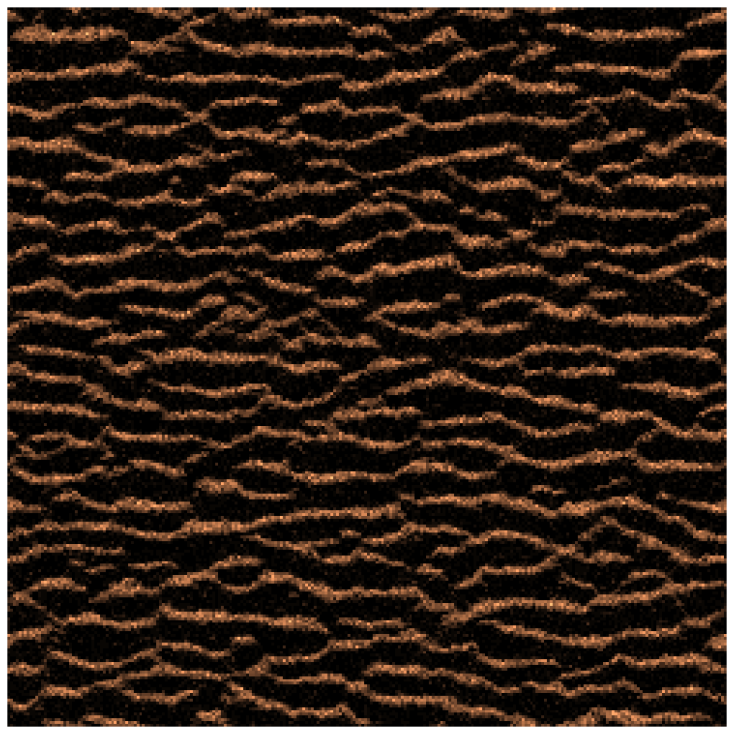

In [8]:
height = wind_ripples(Params())
fig, ax = plt.subplots(figsize=(fig_width, fig_width), subplotpars=subplotpars)
ax.imshow(height.T, vmin=0, vmax=height.max(), cmap=plt.copper())
ax.axis('off');    


Let's try to modify some parameters to see their effect on the obtained patterns:

In [9]:
N_scan = 4

def scan(variable, values):
    print(f'Scanning {variable=} along {values=}')
    N_scan_ = len(values)
    fig, axs = plt.subplots(1, N_scan_, figsize=(fig_width, fig_width/N_scan_), subplotpars=subplotpars)
    for i_scan, value in enumerate(values):
        scan_dict = {variable: value}
        p = Params(**scan_dict)
        print(i_scan, 'params', p)
        height = wind_ripples(p)
        ax = axs[i_scan]
        ax.imshow(height.T, cmap=plt.copper())
        formatted_value = value if (type(value) == int) else f'{values[i_scan]:.2e}'
        ax.set_title(f'{variable}={formatted_value}')
        ax.axis('off')
        
    return fig, axs

First, `kappa` ($\kappa$) controls the slope of the sigmoid, and leads to different patterns, the system bifurcating quickly from one set of pattern to the other :

Scanning variable='kappa' along values=array([ 0.8     ,  2.339214,  6.839904, 20.      ])
0 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=0.8, D=0.0007, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=2.3392141905702926, D=0.0007, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=6.839903786706787, D=0.0007, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=20.0, D=0.0007, seed=1998)


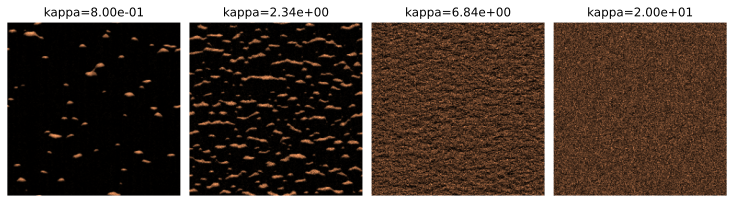

In [10]:
fig, axs = scan('kappa', p.kappa * np.logspace(-1, 1, N_scan, base=5));

Only a limited set of parameters leads to interesting patterns, and we observe a transition from sparse (isolated) to more dense (packed) ripples:

Scanning variable='kappa' along values=array([2.      , 3.174802, 5.039684, 8.      ])
0 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=2.0, D=0.0007, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=3.1748021039363987, D=0.0007, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=5.039684199579493, D=0.0007, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=8.0, D=0.0007, seed=1998)


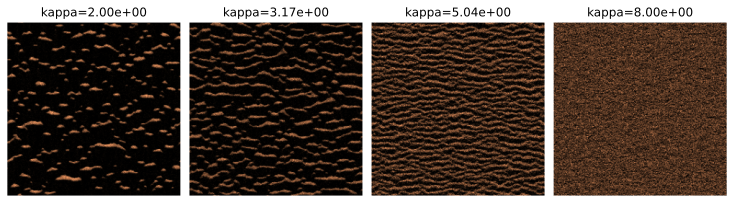

In [11]:
fig, axs = scan('kappa', p.kappa * np.logspace(-1, 1, N_scan, base=2));


The diffusion parameter $D$ has also a striking effect, as it controls in some sort the "viscosity" of the sand grains, the ripples disappearing when too much diffusion occurs:

Scanning variable='D' along values=array([0.00007 , 0.000325, 0.001508, 0.007   ])
0 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=7.000000000000001e-05, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0003249112183528945, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0015081042830223184, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.007, seed=1998)


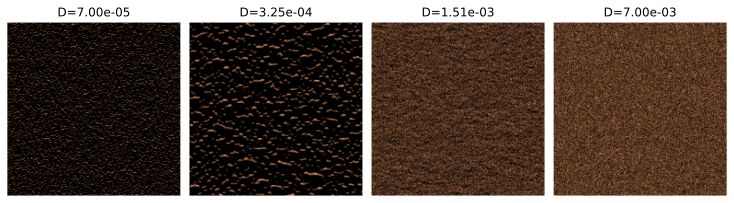

In [12]:
fig, axs = scan('D', p.D * np.logspace(-1, 1, N_scan, base=10));

By "zooming" into this range of parameter, we observe a quite smooth transition  :

Scanning variable='D' along values=array([0.000175, 0.000441, 0.001111, 0.0028  ])
0 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.000175, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0004409723674632056, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0011111807363777396, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0028, seed=1998)


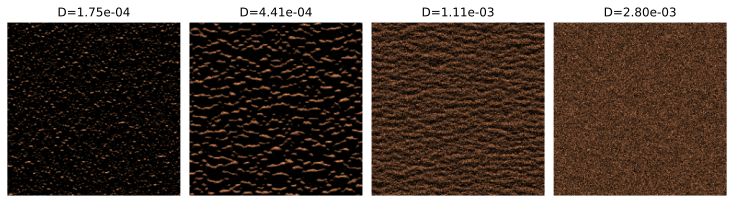

In [13]:
fig, axs = scan('D', p.D * np.logspace(-1, 1, N_scan, base=4));

We may further explore the effect of simulation parameters, respctively the number of simulation steps `N_Steps`:

Scanning variable='N_step' along values=array([  16,  128, 1024, 8192])
0 params Params(bins=256, N_particles=262144, N_step=16, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=128, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=8192, L=0.015625, kappa=4.0, D=0.0007, seed=1998)


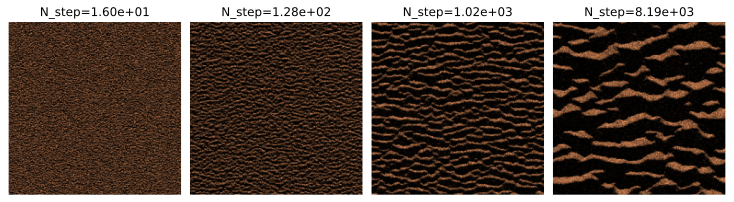

In [14]:
fig, axs = scan('N_step', 2**np.arange(4, 4*N_scan, 3, dtype=int));

the numbers of bins used to compute the height:

Scanning variable='bins' along values=array([ 64, 128, 256, 512])
0 params Params(bins=64, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
1 params Params(bins=128, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
3 params Params(bins=512, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)


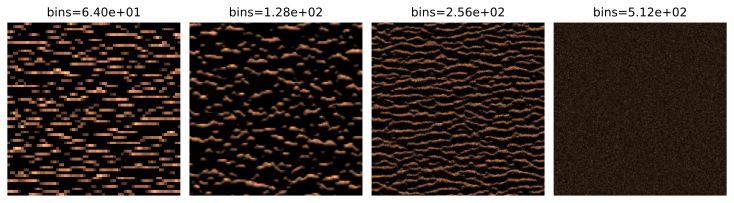

In [15]:
fig, axs = scan('bins', 2**np.arange(6, N_scan+6, dtype=int));

the number of particles, showing that the simulations are stable given a sufficient number of particles:

Scanning variable='N_particles' along values=array([ 131072,  262144,  524288, 1048576])
0 params Params(bins=256, N_particles=131072, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
2 params Params(bins=256, N_particles=524288, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)
3 params Params(bins=256, N_particles=1048576, N_step=1024, L=0.015625, kappa=4.0, D=0.0007, seed=1998)


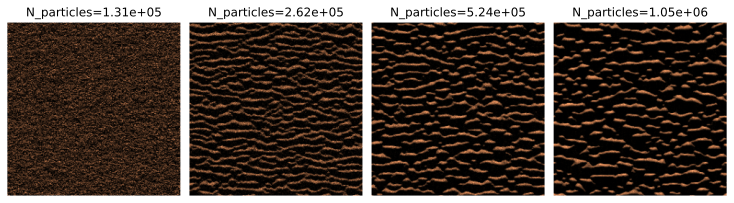

In [16]:
fig, axs = scan('N_particles', (p.bins)**2 * 2**np.arange(1, N_scan+1, dtype=int));

or the saltation length:

Scanning variable='L' along values=array([0.007812, 0.024803, 0.078745, 0.25    ])
0 params Params(bins=256, N_particles=262144, N_step=1024, L=0.0078125, kappa=4.0, D=0.0007, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, L=0.024803141437003108, kappa=4.0, D=0.0007, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, L=0.07874506561842955, kappa=4.0, D=0.0007, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, L=0.25, kappa=4.0, D=0.0007, seed=1998)


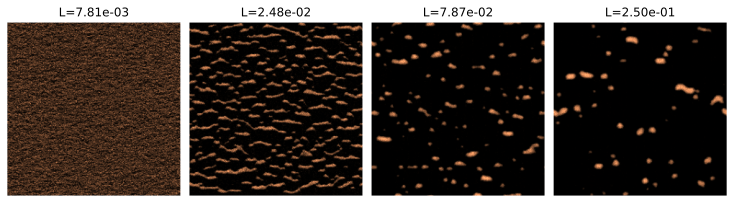

In [17]:
fig, axs = scan('L', np.geomspace(1 / 2**7, 1 / 2**2, N_scan));

## Genrating dune ripples

Dune ripples involve a slightly more complex model which can be defined as the following

In [18]:
@dataclass
class Params:
    bins: int = 2**(8//DEBUG)
    N_particles: int = 2**(8*2) * 4
    N_step: int = 2**(10//DEBUG)
    D: float = .005 # diffusion per step
    b: float = .05
    kappa: float = 10.
    seed : int = 1998

p = Params()
p

Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)

The dynamical system can be formalized as the previous equations, but adding a saltation which depends on the slope.

$$
y_i \leftarrow y_i + L + b \cdot (2\sigma( - \kappa * \nabla_y h(\vec{x}))-1)
$$
where $\nabla_y$ is the slope in the $y$ direction (that is, the gradient of the height in that direction).

First using [numpy](https://numpy.org) on the CPU:

In [19]:
def gradient_y(image):
    # image_ = image.copy()
    grad = np.roll(image, shift=-1, axis=1)
    grad -= np.roll(image, shift=1, axis=1)
    return grad

def dune_ripples(p):
    binz = [np.linspace(0, 1, p.bins+1, endpoint=True), np.linspace(0, 1, p.bins+1, endpoint=True)]
    np.random.seed(p.seed)
    x, y = np.random.rand(p.N_particles), np.random.rand(p.N_particles)

    for i_step in range(p.N_step):
        
        x, y = x + p.D/(i_step+1)*np.random.randn(p.N_particles), y + p.D/(i_step+1)*np.random.randn(p.N_particles)    
        x, y = x % 1, y % 1

        height, edge_x, edge_y = np.histogram2d(x, y, bins=binz, density=True)
        slope = gradient_y(height)

        ind_x, ind_y = (x*p.bins).astype(int), (y*p.bins).astype(int)

        y += p.b * np.tanh( - p.kappa * slope[ind_x, ind_y])

    return height, slope

height, slope = dune_ripples(Params())   

Then using [pyTorch](https://pytorch.org):

In [20]:
def gradient_y(image):
    # image_ = image.copy()
    grad = torch.roll(image, shifts=(0, -1), dims=(0, 1))
    grad -= torch.roll(image, shifts=(0, 1), dims=(0, 1))
    return grad

def dune_ripples(p):
    with torch.no_grad():

        binz = (torch.linspace(0, 1, p.bins+1), torch.linspace(0, 1, p.bins+1))
        
        np.random.seed(p.seed)
        pos = torch.rand(p.N_particles, 2)

        for i_step in range(p.N_step):
            # pos += p.D/torch.sqrt(torch.tensor(i_step+1))*torch.randn(p.N_particles, 2)
            pos += p.D*torch.randn(p.N_particles, 2)
            pos = pos % 1

            # https://pytorch.org/docs/stable/generated/torch.histogramdd.html
            height, edge_pos = torch.histogramdd(pos, bins=binz, density=True)
            slope = gradient_y(height)

            ind_pos = torch.ceil(pos*p.bins).long() - 1
            pos[:, 1] += p.b * torch.tanh( - p.kappa * slope[ind_pos[:, 0], ind_pos[:, 1]])
        
    return height.numpy(), slope.numpy()

height, slope = dune_ripples(p = Params())

The system leads to a very resembling pattern which has more structural complexity with the wind ripples that we generated above:

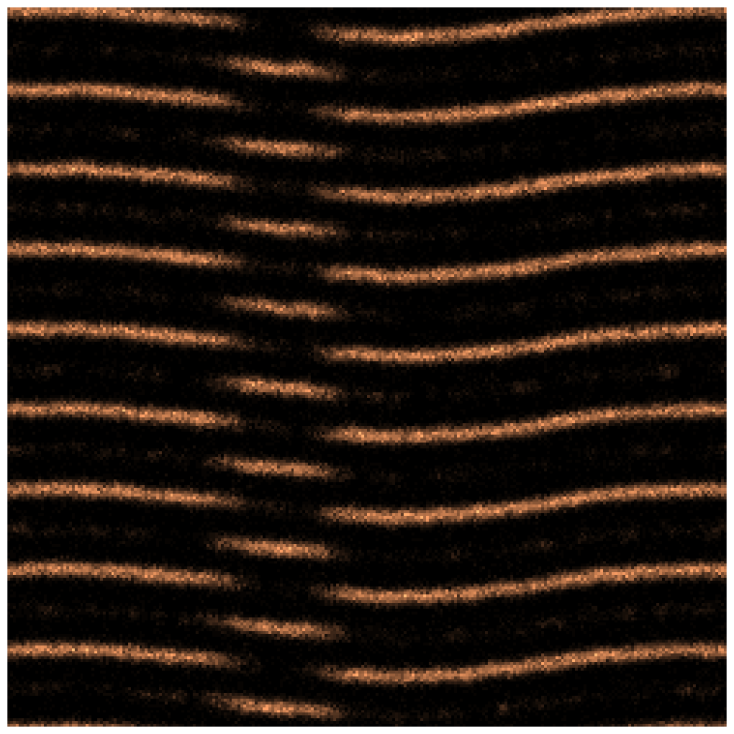

In [21]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width), subplotpars=subplotpars)
ax.imshow(height.T, cmap=plt.copper())
ax.axis('off'); 

In [22]:
def scan(variable, values):
    print(f'Scanning {variable=} along {values=}')
    N_scan_ = len(values)
    fig, axs = plt.subplots(1, N_scan_, figsize=(fig_width, fig_width/N_scan_), subplotpars=subplotpars)
    for i_scan, value in enumerate(values):
        scan_dict = {variable: value}
        p = Params(**scan_dict)
        print(i_scan, 'params', p)
        height, slope = dune_ripples(p)
        ax = axs[i_scan]
        ax.imshow(height.T, cmap=plt.copper())
        formatted_value = value if (type(value) == int) else f'{values[i_scan]:.2e}'
        ax.set_title(f'{variable}={formatted_value}')
        ax.axis('off')
        
    return fig, axs

the dune-like patterns can be observed for a set of parameters:

Scanning variable='kappa' along values=array([  0.769231,   4.252904,  23.513347, 130.      ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=0.7692307692307693, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=4.252903702829901, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=23.513346877207567, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=130.0, seed=1998)


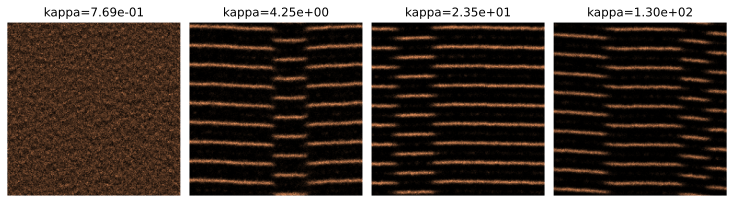

In [23]:
fig, axs = scan('kappa', p.kappa * np.logspace(-1, 1, N_scan, base=13));

Scanning variable='kappa' along values=array([ 2.      ,  5.848035, 17.099759, 50.      ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=2.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=5.848035476425731, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=17.09975946676697, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=50.0, seed=1998)


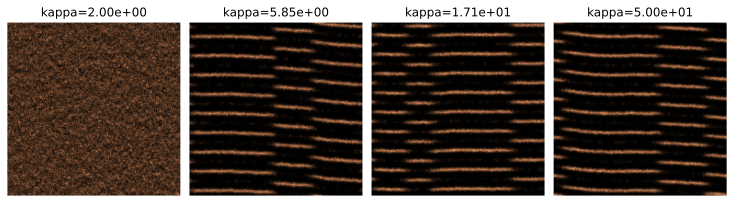

In [24]:
fig, axs = scan('kappa', p.kappa * np.logspace(-1, 1, N_scan, base=5));

The diffusion pattern seems to control the frequency and length of the stripes, with quite abrupt bifurcations:

Scanning variable='D' along values=array([0.00025 , 0.001842, 0.013572, 0.1     ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.00025, b=0.05, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.0018420157493201931, b=0.05, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.01357208808297453, b=0.05, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.1, b=0.05, kappa=10.0, seed=1998)


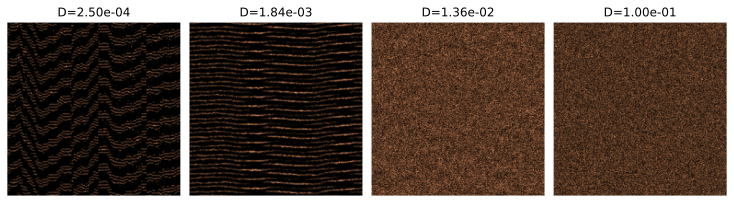

In [25]:
fig, axs = scan('D', p.D * np.logspace(-1, 1, N_scan, base=20));

Scanning variable='D' along values=array([0.00125 , 0.00315 , 0.007937, 0.02    ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.00125, b=0.05, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.003149802624737183, b=0.05, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.007937005259840996, b=0.05, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.02, b=0.05, kappa=10.0, seed=1998)


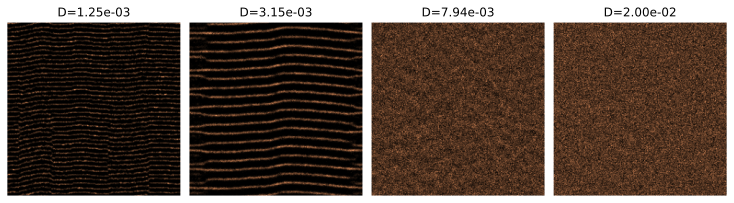

In [26]:
fig, axs = scan('D', p.D * np.logspace(-1, 1, N_scan, base=4));

While `b` controls the stability

Scanning variable='b' along values=array([0.002381, 0.018123, 0.137946, 1.05    ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.002380952380952381, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.01812300621671487, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.137946208819056, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=1.05, kappa=10.0, seed=1998)


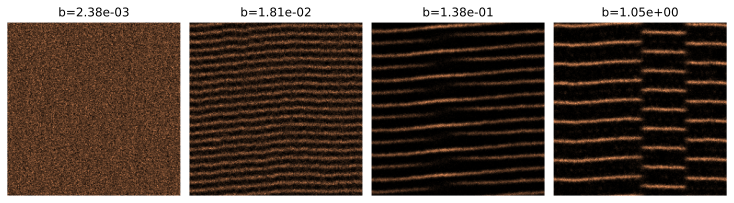

In [27]:
fig, axs = scan('b', p.b * np.logspace(-1, 1, N_scan, base=21));

and interestingly, the frequency may decrease and increase again:

Scanning variable='b' along values=array([0.01    , 0.02924 , 0.085499, 0.25    ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.010000000000000002, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.029240177382128658, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.08549879733383485, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.25, kappa=10.0, seed=1998)


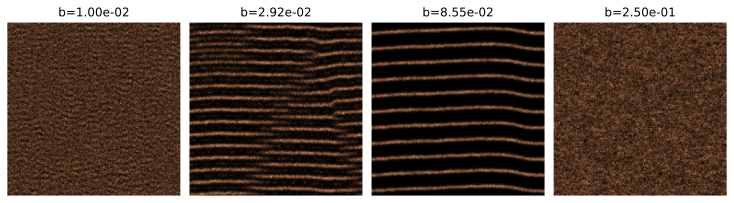

In [28]:
fig, axs = scan('b', p.b * np.logspace(-1, 1, N_scan, base=5));

Scanning variable='b' along values=array([0.016667, 0.034668, 0.072112, 0.15    ])
0 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.016666666666666666, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.034668063717531734, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.07211247851537042, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.15000000000000002, kappa=10.0, seed=1998)


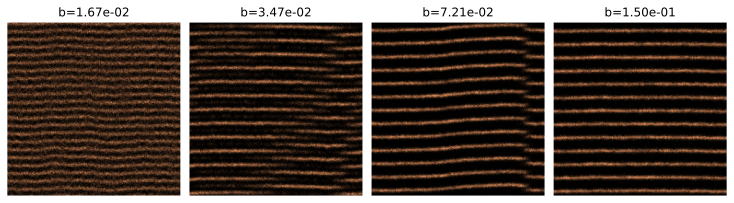

In [29]:
fig, axs = scan('b', p.b * np.logspace(-1, 1, N_scan, base=3));

Similarly, we may  explore the effect of simulation parameters:

Scanning variable='N_step' along values=array([  16,  128, 1024, 8192])
0 params Params(bins=256, N_particles=262144, N_step=16, D=0.005, b=0.05, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=128, D=0.005, b=0.05, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=8192, D=0.005, b=0.05, kappa=10.0, seed=1998)


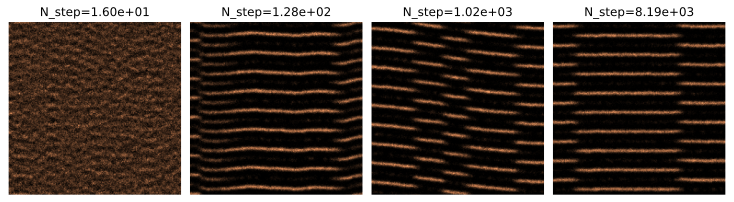

In [30]:
fig, axs = scan('N_step', 2**np.arange(4, 4*N_scan, 3, dtype=int));

Scanning variable='bins' along values=array([ 32,  64, 128, 256])
0 params Params(bins=32, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
1 params Params(bins=64, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
2 params Params(bins=128, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)


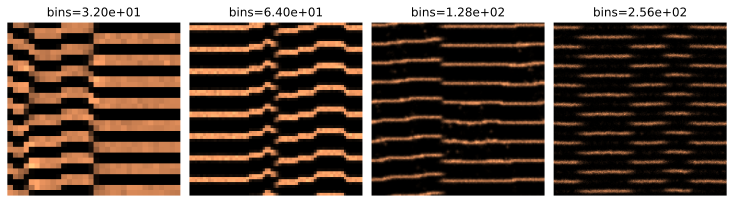

In [31]:
fig, axs = scan('bins', 2**np.arange(5, N_scan+5, dtype=int));

Scanning variable='N_particles' along values=array([ 131072,  262144,  524288, 1048576])
0 params Params(bins=256, N_particles=131072, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
1 params Params(bins=256, N_particles=262144, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
2 params Params(bins=256, N_particles=524288, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)
3 params Params(bins=256, N_particles=1048576, N_step=1024, D=0.005, b=0.05, kappa=10.0, seed=1998)


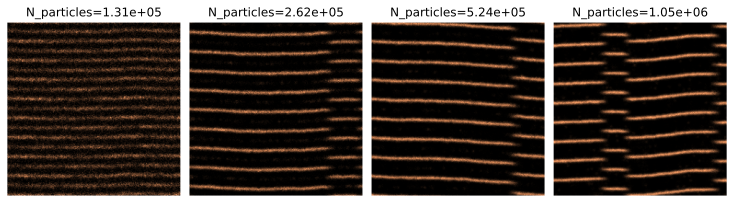

In [32]:
fig, axs = scan('N_particles', (p.bins)**2 * 2**np.arange(1, N_scan+1, dtype=int));

## Conclusion

As a conclusion, we could easily generate ripple and dune patterns. They form some class of reaction diffusion system, where the reaction is the accumulation of sand and the diffusion is the stronger effect of wind on differential areas of the pattern. We provide an implementation on numpy and a faster one using pyTorch.

We have provided an original implementation combining a particle-based representation with a dense interaction map allowing to generate maps in a few seconds. Future extensions should study and more thoroughly the bifurcation maps, for instance by showing the evolution of the spectrum in each direction as a function of the parameters, and -why not- spend some time predicting them analytically :-)

## Appendix: version of the libraries that were used

In [33]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,torch,matplotlib  -r -g -b

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.11.0

numpy     : 1.24.3
torch     : 2.0.0
matplotlib: 3.7.1

Compiler    : Clang 14.0.0 (clang-1400.0.29.202)
OS          : Darwin
Release     : 22.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local

Git hash: 4049a8e9ceb83c83a7bf6d19b3e1011c552bdbfe

Git repo: https://github.com/laurentperrinet/sciblog.git

Git branch: master

